# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. During these phone campaigns, an attractive long-term deposit
application, with good interest rates, was offered. For each contact, a large number of attributes was stored and if there was a success (the target variable).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, roc_curve, auc, confusion_matrix
import time

In [8]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



<Axes: xlabel='y'>

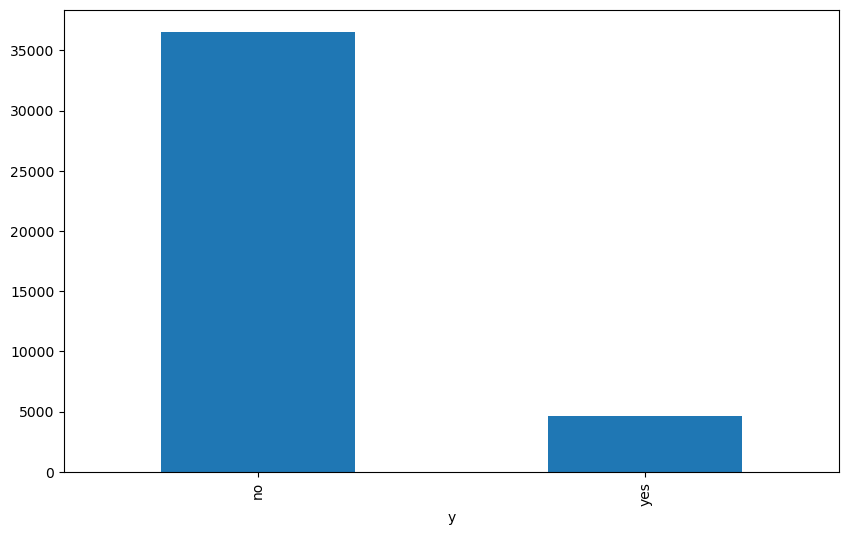

In [12]:
df['y'].value_counts().plot(kind='bar', figsize=(10,6))

Notes: As we see that the outcomes are not uniformly distributed, we will need to stratify the outcome data in train_test_split function.

Plotting the distibution of outcome with respect to each of the features in the dataset

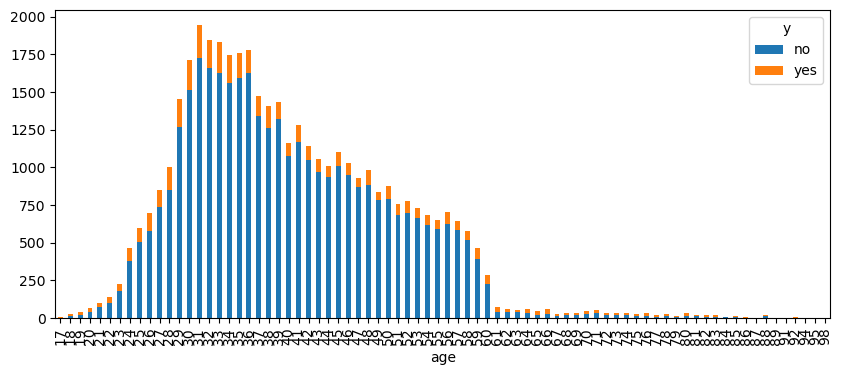

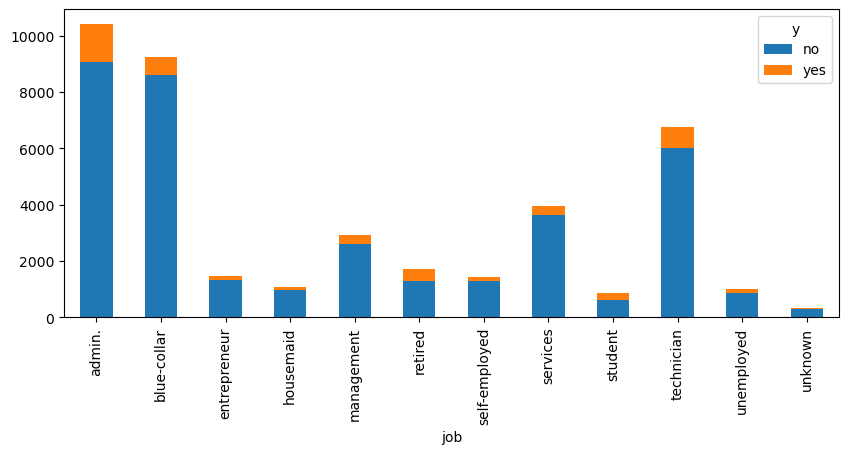

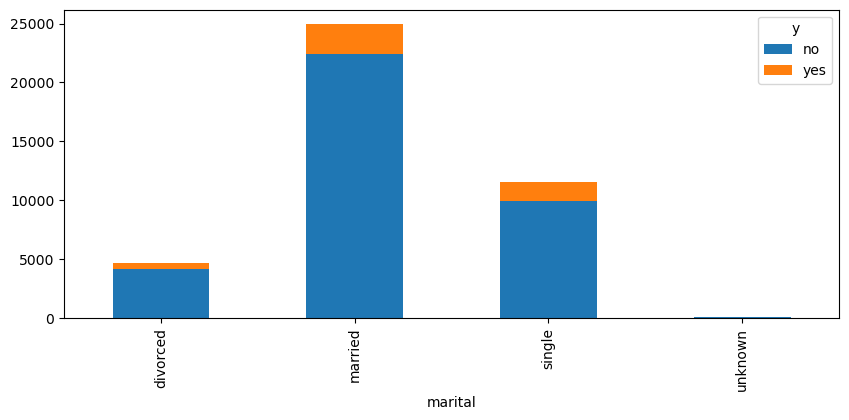

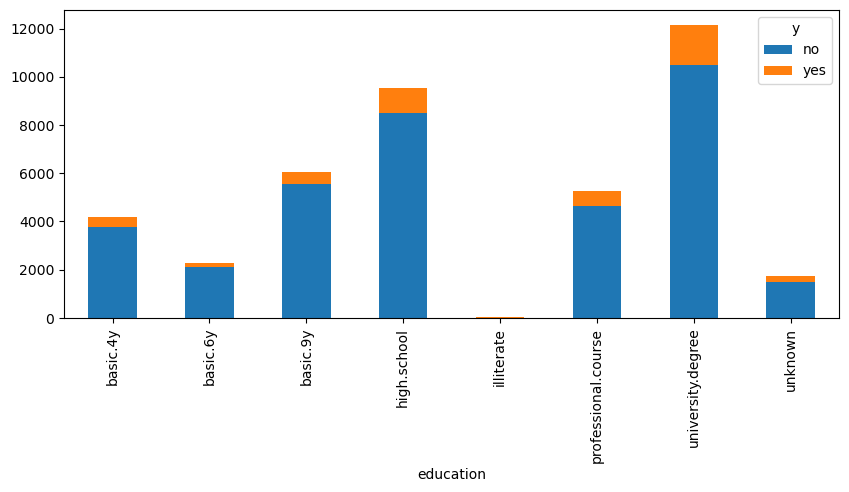

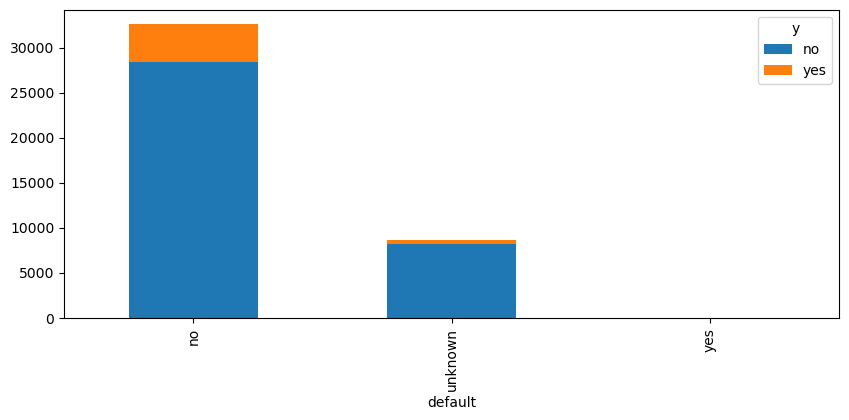

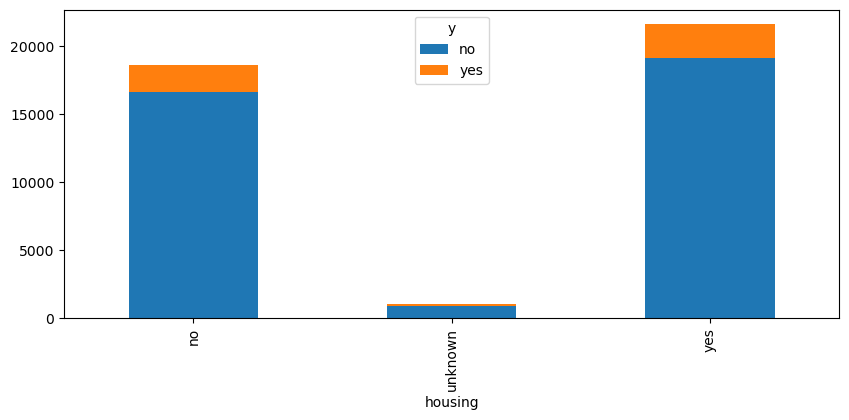

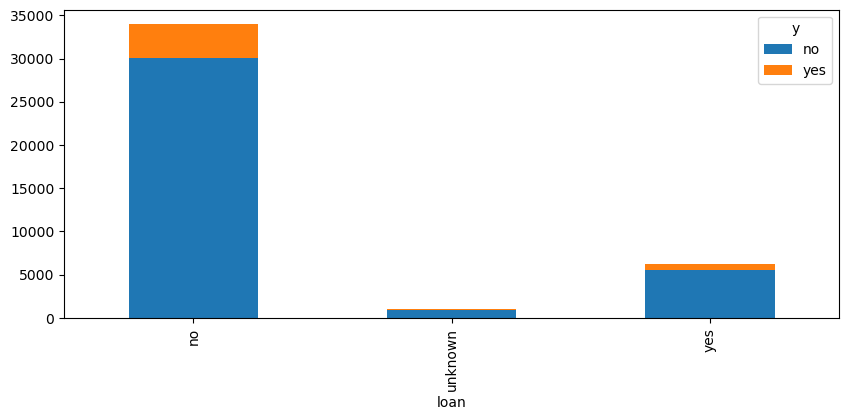

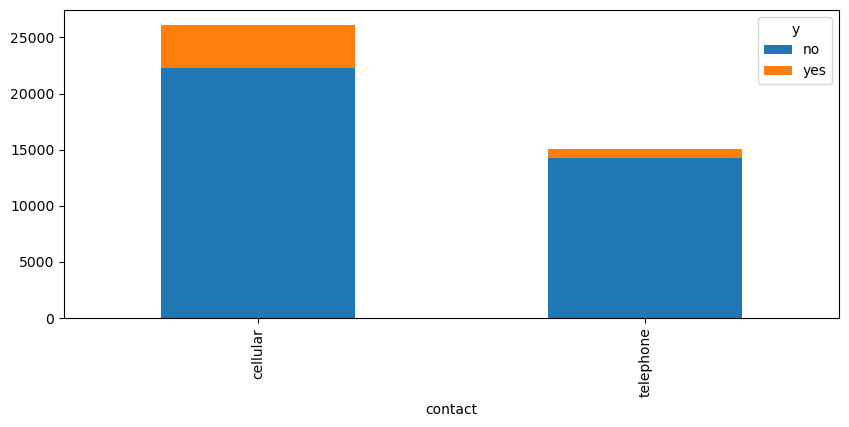

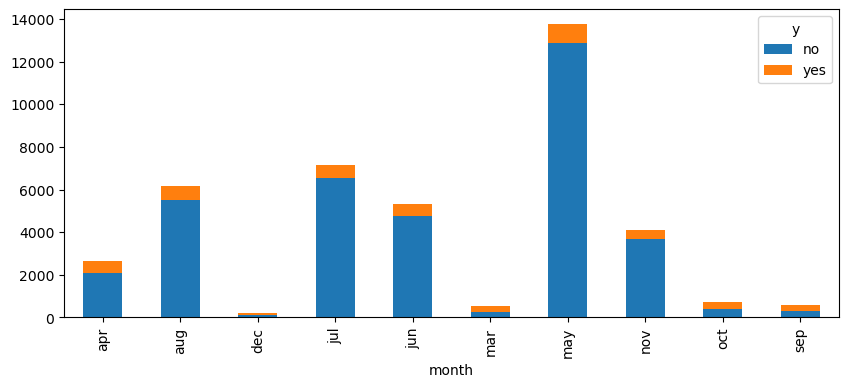

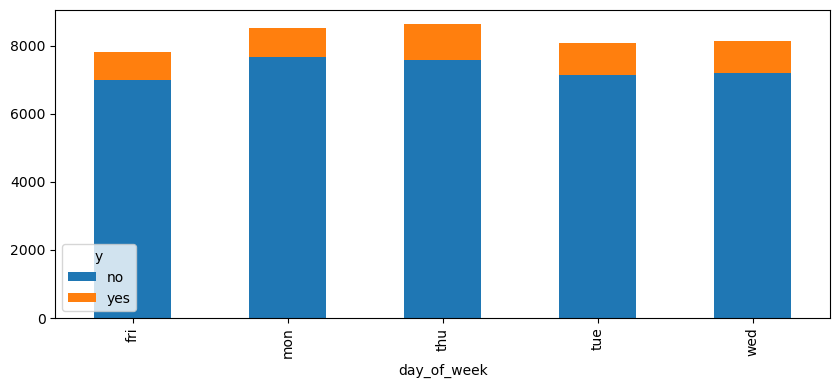

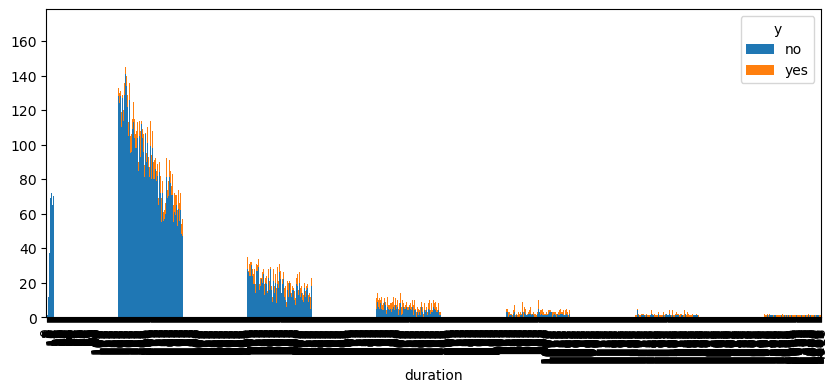

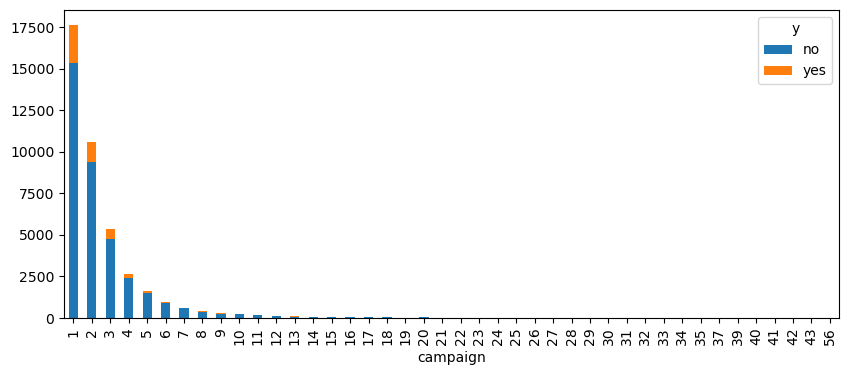

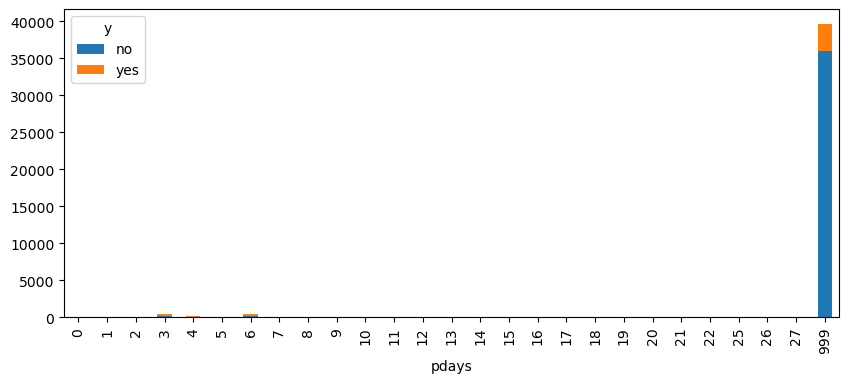

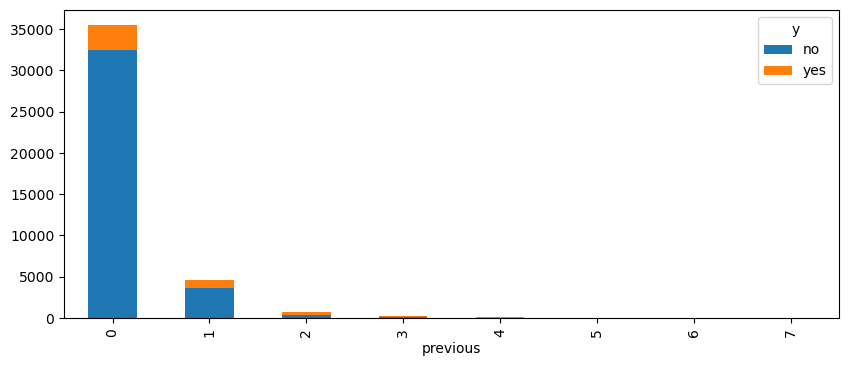

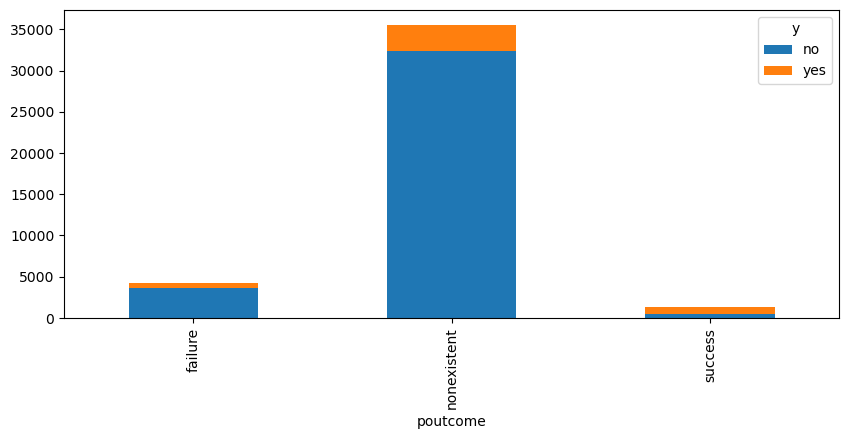

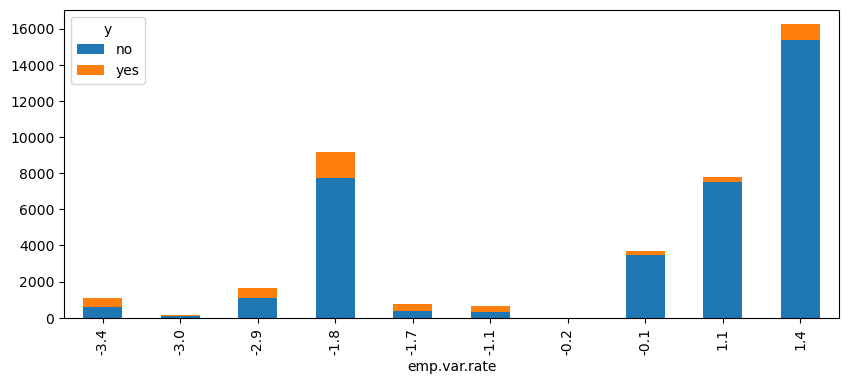

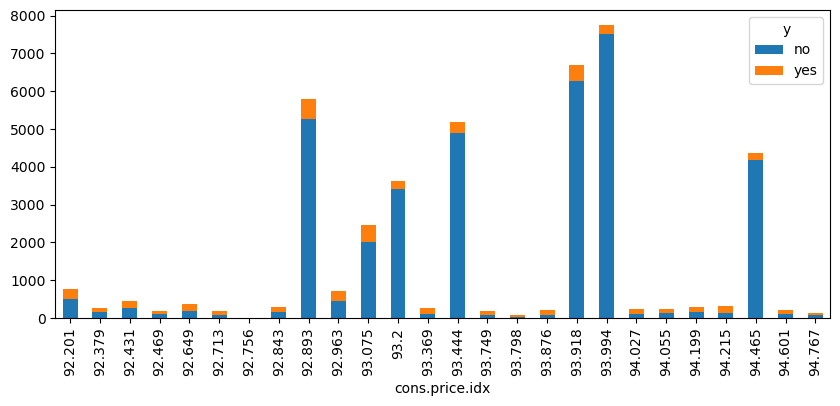

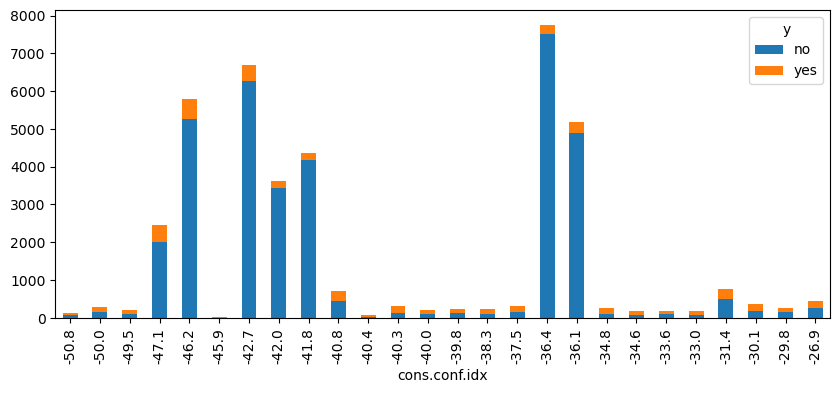

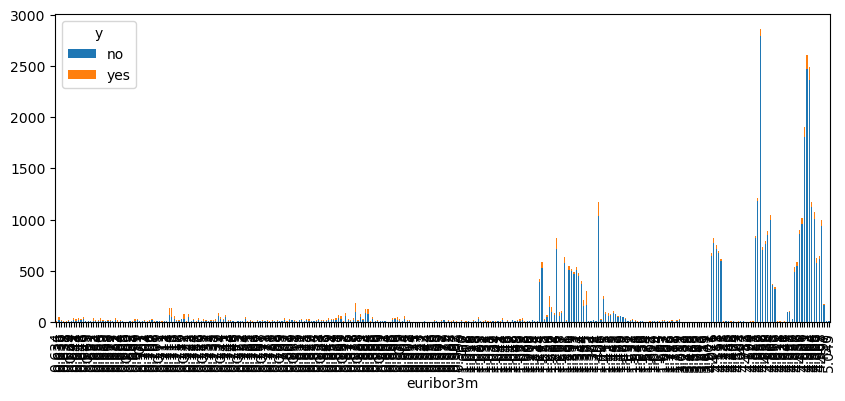

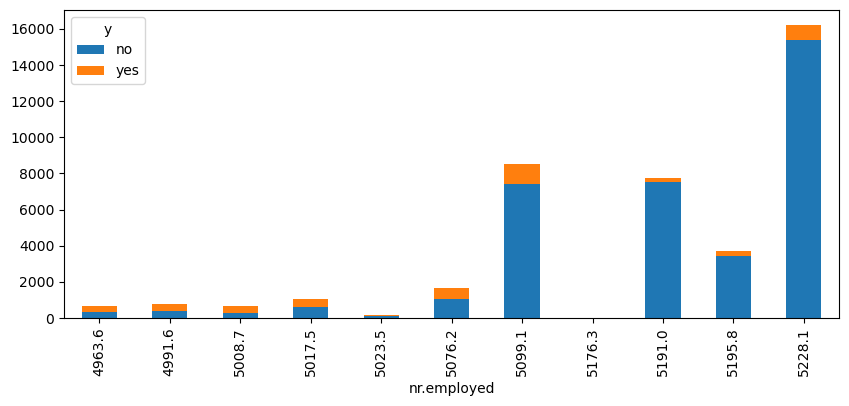

In [15]:
for feature in df.drop('y', axis = 1).columns:
        pd.crosstab(df[feature], df['y']).plot(kind='bar', stacked=True, figsize=(10,4))

In [16]:
# Determining the outliners for features based on iqr
def outliers_filter(df, column):
    factor = 1.5
    first_quartile = df[column].quantile(.25)
    third_quartile = df[column].quantile(.75)
    iqr = third_quartile - first_quartile
    lower = first_quartile - factor*iqr
    upper = third_quartile + factor*iqr
    print( f'{ column } -> lower: { lower }, upper: { upper }')
    return

Based the above distribution determine the outlier for age and campaign features

In [18]:
outliers_filter(df, 'age')

age -> lower: 9.5, upper: 69.5


In [19]:
outliers_filter(df, 'campaign')

campaign -> lower: -2.0, upper: 6.0


Create and DataFrame dropping the following features:
1) duration ( as its collected after the fact and may not be accurate to include in model training)
2) social and economic context attributes ('emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed')

In [21]:
df = df.drop(['duration', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m', 'nr.employed' ], axis=1)

In [22]:
# Applying the outliers filter on dataframe
df = df[(df['age'] <= 70) & (df['age'] > 9)]
df = df[(df['campaign'] <= 6) & (df['campaign'] >= 0)]

Re-Plotting the distibution of outcome with respect to each of the features in the dataset after 

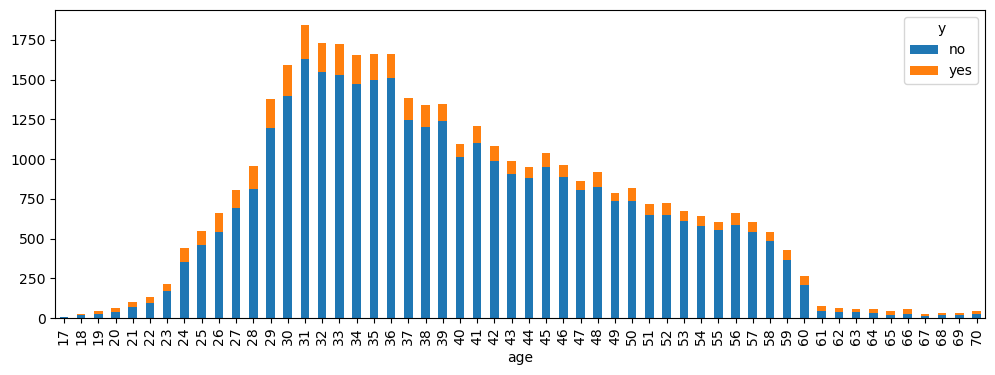

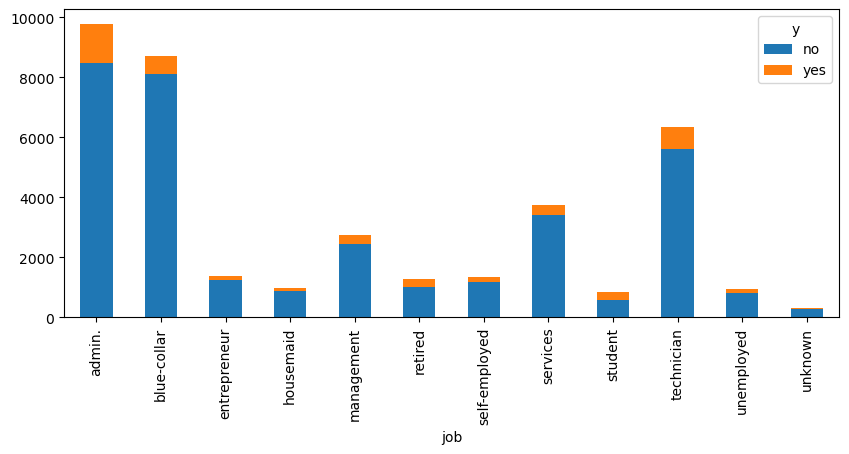

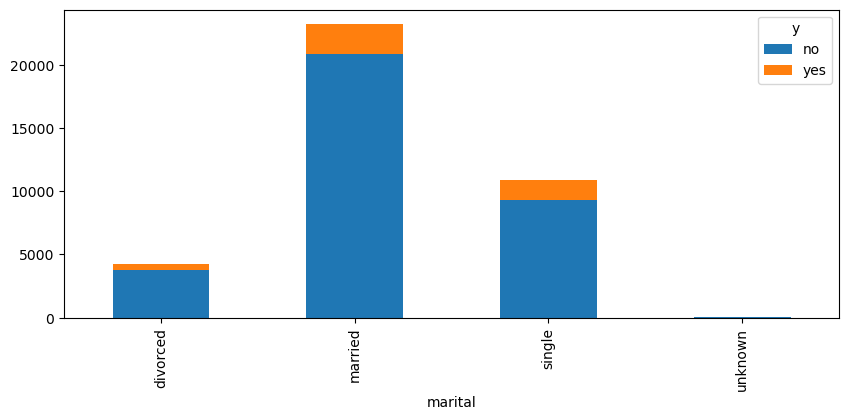

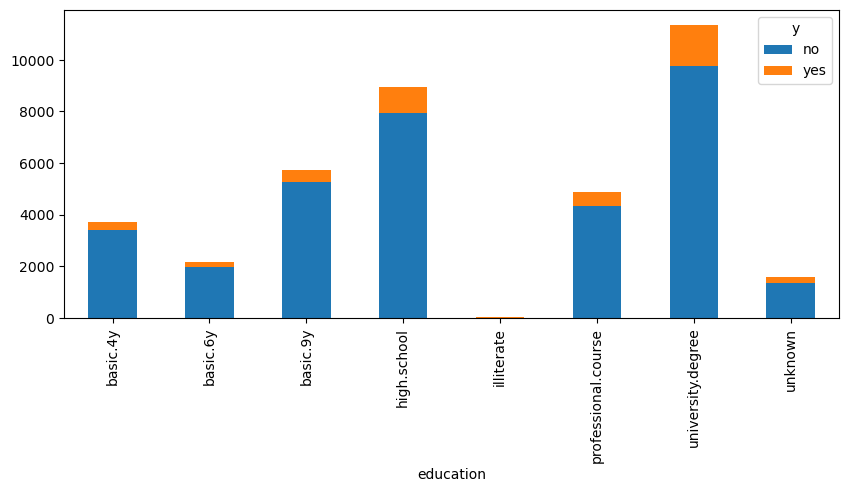

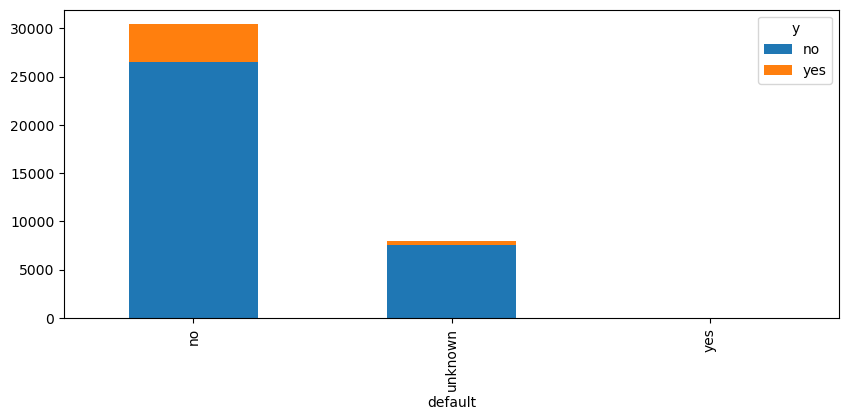

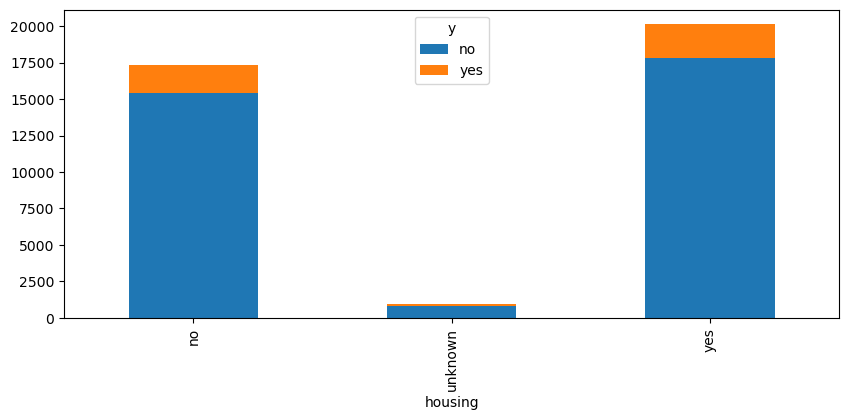

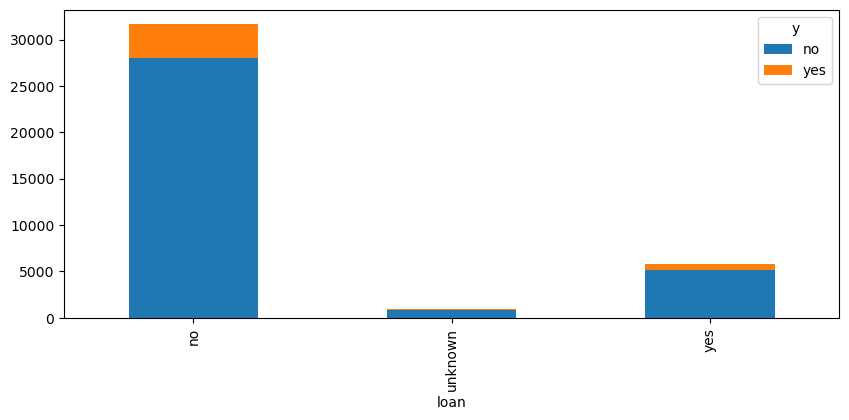

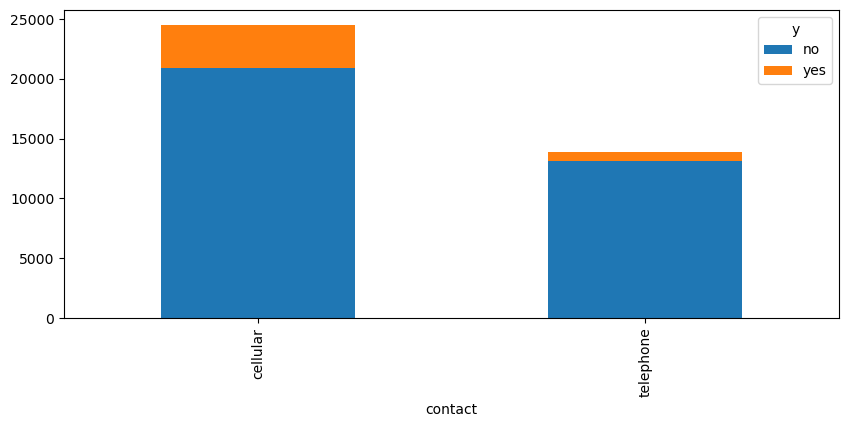

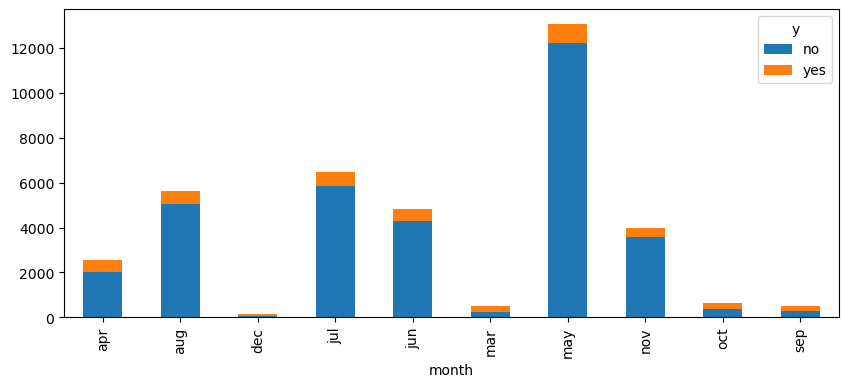

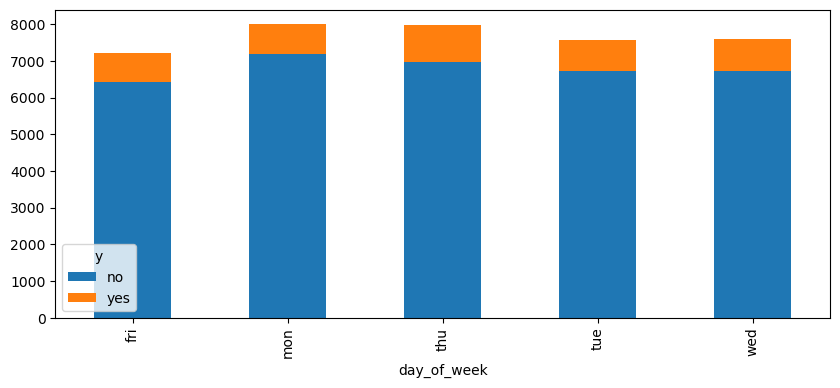

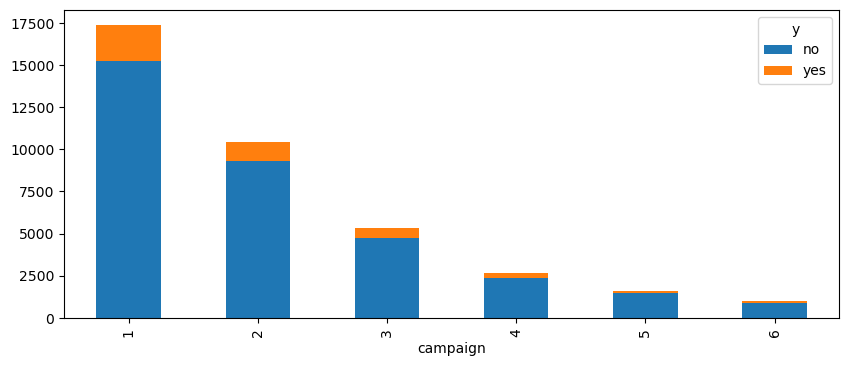

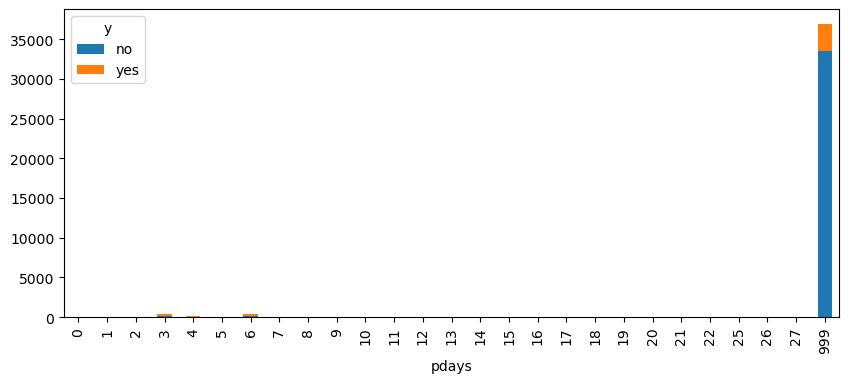

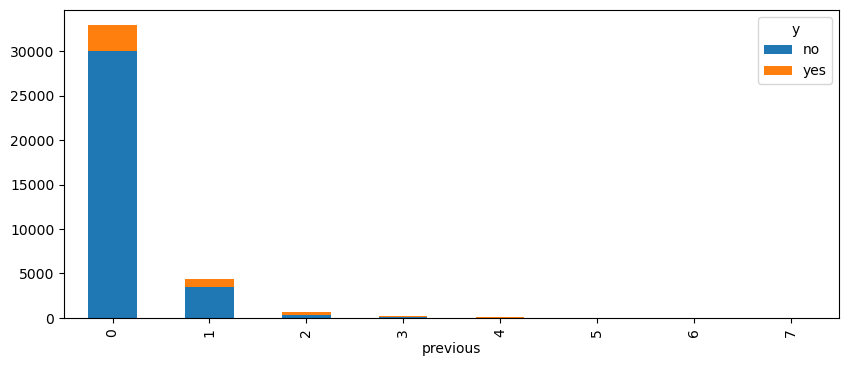

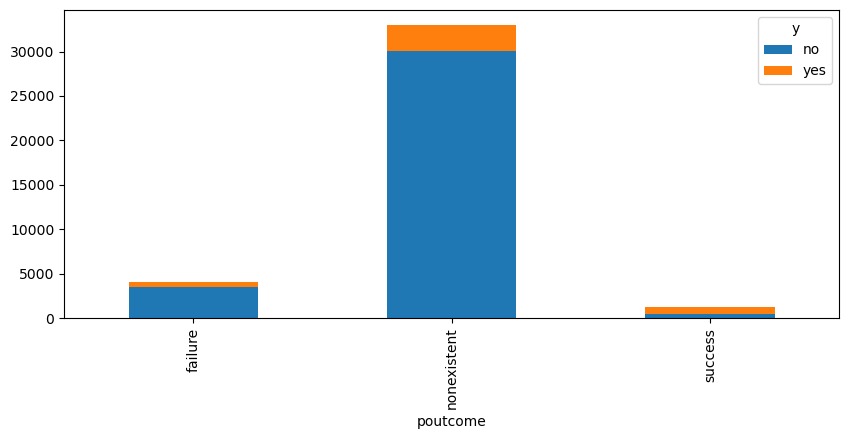

In [24]:
for feature in df.drop('y', axis = 1).columns:
    if feature == 'age':
        pd.crosstab(df[(df['age'] <= 70) & (df['age'] > 9)]['age'], df['y']).plot(kind='bar', stacked=True, figsize=(12, 4))
    elif feature == 'campaign':
        pd.crosstab(df[(df['campaign'] <= 6) & (df['campaign'] >= 0)]['campaign'], df['y']).plot(kind='bar', stacked=True, figsize=(10,4))
    else:
        pd.crosstab(df[feature], df['y']).plot(kind='bar', stacked=True, figsize=(10,4))

In [25]:
df['pdays'].value_counts()

pdays
999    36961
3        403
6        379
4        111
2         59
9         59
7         56
12        56
10        49
5         45
13        34
11        27
1         25
15        22
14        18
8         17
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Business Objective: 
For targeted direct marketing campaign Identify the main driving factors that contribute to customer able to sucessfully open a long term direct deposit account. 

Notes: Deploying the model after applying these factors and running a sample A/B test will evaluate the model on mse between predicted output to actual output. 

In [28]:
df.isna().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38374 entries, 0 to 41186
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          38374 non-null  int64 
 1   job          38374 non-null  object
 2   marital      38374 non-null  object
 3   education    38374 non-null  object
 4   default      38374 non-null  object
 5   housing      38374 non-null  object
 6   loan         38374 non-null  object
 7   contact      38374 non-null  object
 8   month        38374 non-null  object
 9   day_of_week  38374 non-null  object
 10  campaign     38374 non-null  int64 
 11  pdays        38374 non-null  int64 
 12  previous     38374 non-null  int64 
 13  poutcome     38374 non-null  object
 14  y            38374 non-null  object
dtypes: int64(4), object(11)
memory usage: 5.7+ MB


In [30]:
# Identifying and storing numerical features in numerical_columns
numerical_columns = []
for col in df.columns:
    if df[col].dtypes in ['float64', 'int64']:
        numerical_columns.append(col)
print(numerical_columns)

['age', 'campaign', 'pdays', 'previous']


In [31]:
# Identifying and storing categorical features in categorical_columns
categorical_columns = []
for col in df.columns:
    if df[col].dtypes in ['object']:
        categorical_columns.append(col)
print(categorical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


Text(0.5, 1.0, 'Correlation Matrix of the numerical features')

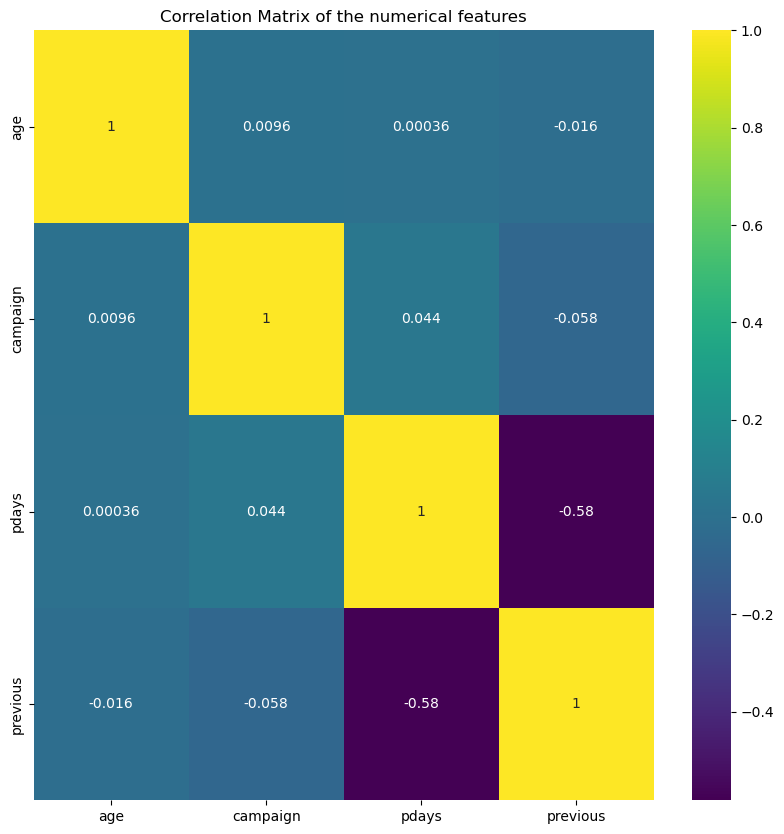

In [32]:
# Plotting the heatmap for numerical columns
plt.figure(figsize=(10, 10))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='viridis')
plt.title('Correlation Matrix of the numerical features')

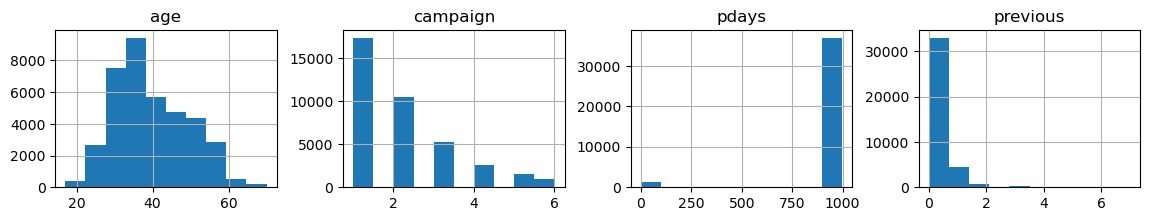

In [33]:
# Distribution of dataset in numerical columns
df[numerical_columns].hist(figsize=(14,10), layout=(4,4));

In [34]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,no


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [36]:
# Function to apply Label Encoding for categorical columns
def label_encode(series):
    le = LabelEncoder()
    return le.fit_transform(series.fillna('Missing'))

In [37]:
# Label Encode categorical values
for feature in categorical_columns:
    df[feature] = label_encode(df[feature])

In [38]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,56,3,1,0,0,0,0,1,6,1,1,999,0,1,0
1,57,7,1,3,1,0,0,1,6,1,1,999,0,1,0
2,37,7,1,3,0,2,0,1,6,1,1,999,0,1,0
3,40,0,1,1,0,0,0,1,6,1,1,999,0,1,0
4,56,7,1,3,0,0,2,1,6,1,1,999,0,1,0


Text(0.5, 1.0, 'Correlation Matrix of the categorical features')

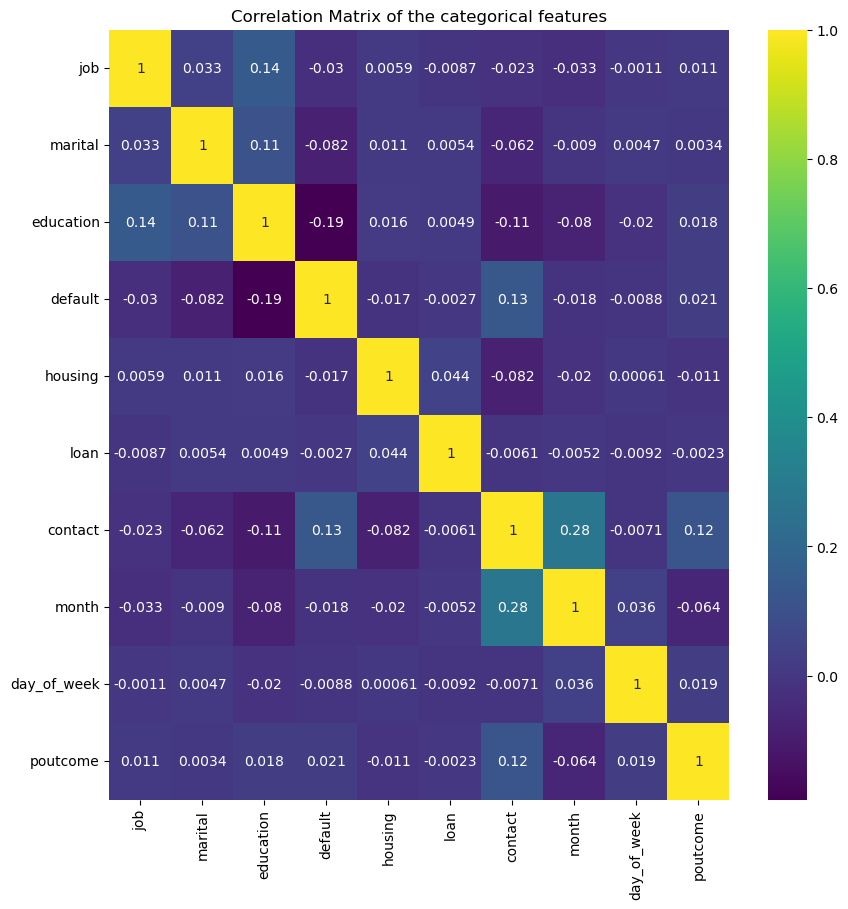

In [39]:
# Plotting the heatmap for categorical columns
plt.figure(figsize=(10, 10))
sns.heatmap(df[categorical_columns].drop('y', axis=1).corr(), annot=True, cmap='viridis')
plt.title('Correlation Matrix of the categorical features')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [41]:
X = df.drop('y', axis = 1)

In [42]:
y = df['y']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [45]:
numeric_transformer = Pipeline(
    steps=[ ("scaler", StandardScaler())]
)

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
    ]
)

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [48]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [49]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous'])])),
                ('classifier', LogisticRegression())])

### Problem 9: Score the Model

What is the accuracy of your model?

In [51]:
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.897


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [53]:
# Initialize models
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'SVC': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier()
}

In [54]:
# Function to plot the confusion matrix
def plot_confusion_matrix(ax, cm, model_name):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

In [55]:
# Function to plot the ROC Curve
def plot_roc_curve(ax, fpr, tpr, auc_value, model_name):
    ax.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc_value:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc='lower right')

In [56]:
# Plot the ROC snd Store model results
results_default = []

def basic_model_eval_stats(models, X_train, y_train, X_test, y_test, results_default):
    # Loop through models and apply Pipelines, then store results
    for model_name, model in models.items():
        print(f"Training {model_name} with Pipeline...")
        
        # Create a Pipeline with StandardScaler and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # First step: Scale the data
            ('model', model)               # Second step: Model fitting
        ])
        
        # Start the timer for training
        start_time = time.time()
        pipeline.fit(X_train, y_train) 
        fit_time = time.time() - start_time
        
        # Predict on test set
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test) #if hasattr(pipeline, 'predict_proba') else None  # For ROC AUC calculation
        
        # Get the classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        test_mse = mean_squared_error(y_test, y_pred)
        
        # Train score (accuracy on training set)
        train_score = pipeline.score(X_train, y_train)
        
        # Test score (accuracy on test set)
        test_score = pipeline.score(X_test, y_test)
        
        # Extract Precision, Recall, F1-score, and Accuracy for each model
        precision = report['accuracy']  # Overall accuracy for the model
        recall = np.mean([report[str(i)]['recall'] for i in report if i.isdigit()])  # Average recall across classes
        accuracy = report['accuracy']  # Accuracy is already included in the classification report

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # ROC Curve and AUC compute and plot
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])  # For binary classification, using class 1 probabilities
        roc_auc = auc(fpr, tpr)
                    
        # Create subplots for Confusion Matrix and ROC Curve
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
        # Plot Confusion Matrix
        plot_confusion_matrix(axs[0], cm, model_name)
        # Plot ROC Curve :
        plot_roc_curve(axs[1], fpr, tpr, roc_auc, model_name)
        plt.tight_layout()
        plt.show()
        
        # Record the results
        results_default.append({
            'model': model_name,
            'train score': train_score,
            'test score': test_score,
            'train time': fit_time,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'roc_auc': roc_auc
        })


Training KNN with Pipeline...


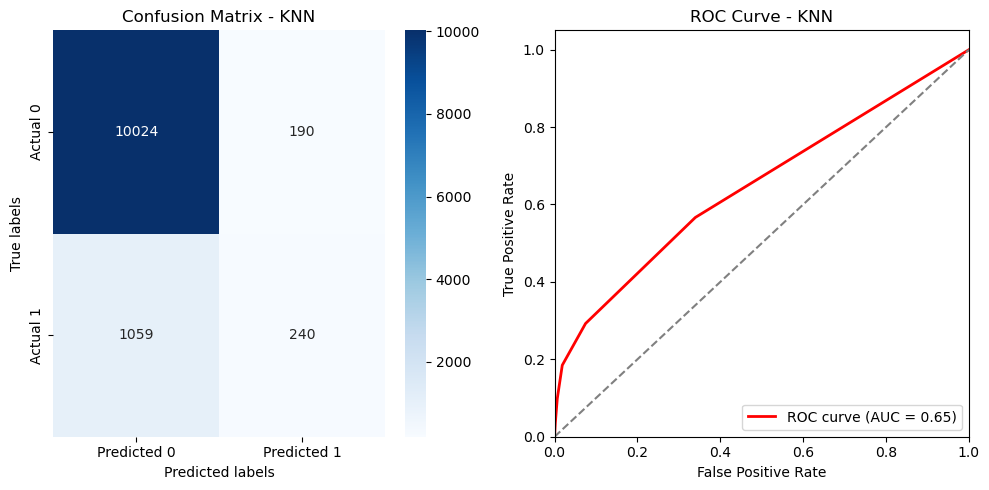

Training Logistic Regression with Pipeline...


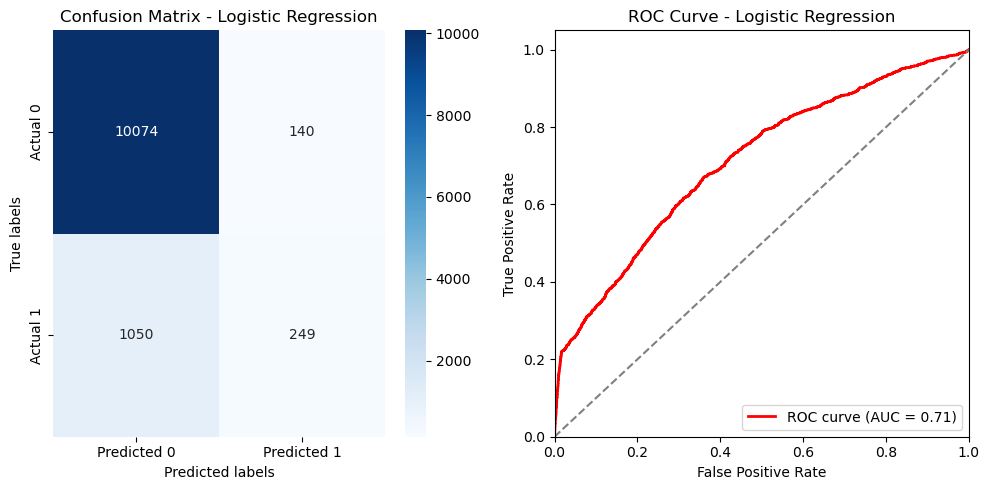

Training SVC with Pipeline...


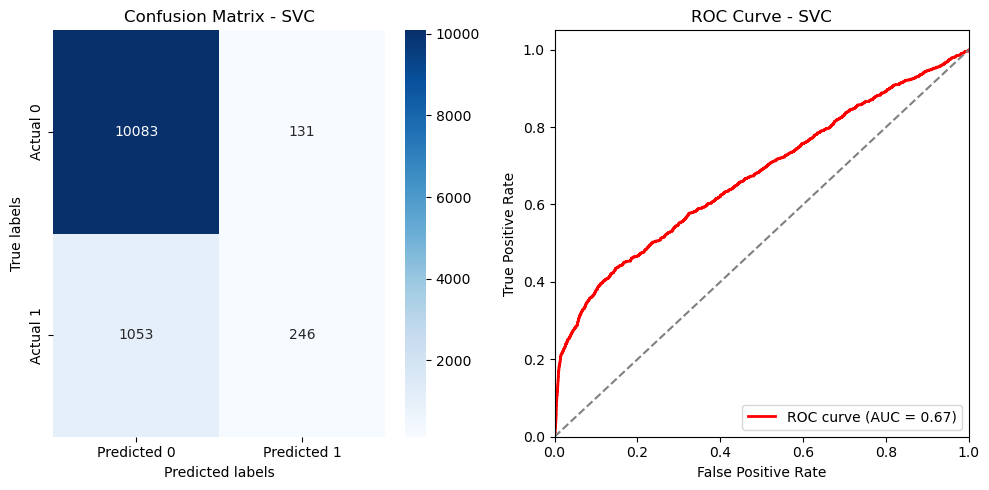

Training Decision Tree with Pipeline...


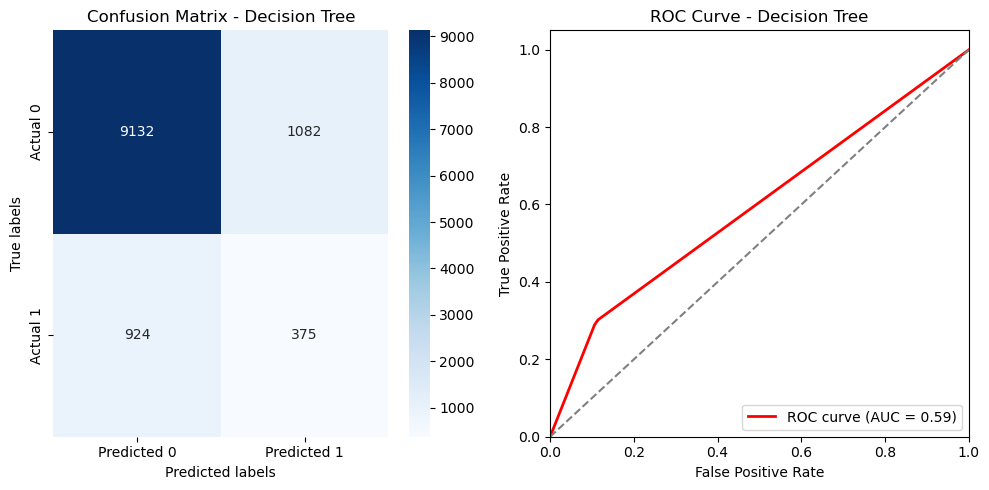

In [57]:
basic_model_eval_stats(models, X_train, y_train, X_test, y_test, results_default)

In [58]:
# Convert results into DataFrame
results_default_df = pd.DataFrame(results_default)

In [59]:
results_default_df

,model,train score,test score,train time,precision,recall,accuracy,roc_auc
0,KNN,0.905551,0.891514,0.293000,0.891514,0.583078,0.891514,0.646423
1,Logistic Regression,0.897286,0.896639,0.082001,0.896639,0.588990,0.896639,0.710188
2,SVC,0.900264,0.897160,557.419254,0.897160,0.588275,0.897160,0.672609
3,Decision Tree,0.993485,0.825762,0.181454,0.825762,0.591375,0.825762,0.594339


In [60]:
# Plotting Model Performance
def plot_graphs(results_df):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot for Train Score and Test Score
    ax[0].bar(results_df['model'], results_df['train score'], label='Train Score', alpha=0.6, color='orange', width=0.3)
    ax[0].bar(results_df['model'], results_df['test score'], label='Test Score', alpha=0.6, color='green', width=0.3, align='edge')
    ax[0].set_title('Train vs Test Score')
    ax[0].set_xlabel('Model')
    ax[0].set_ylabel('Score')
    ax[0].legend()
    
    # Plot for Average Fit Time
    ax[1].bar(results_df['model'], results_df['train time'], color='red', alpha=0.7, width=0.3, align='edge')
    ax[1].set_title('Train Time for Each Model')
    ax[1].set_xlabel('Model')
    ax[1].set_ylabel('Train Time (seconds)')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

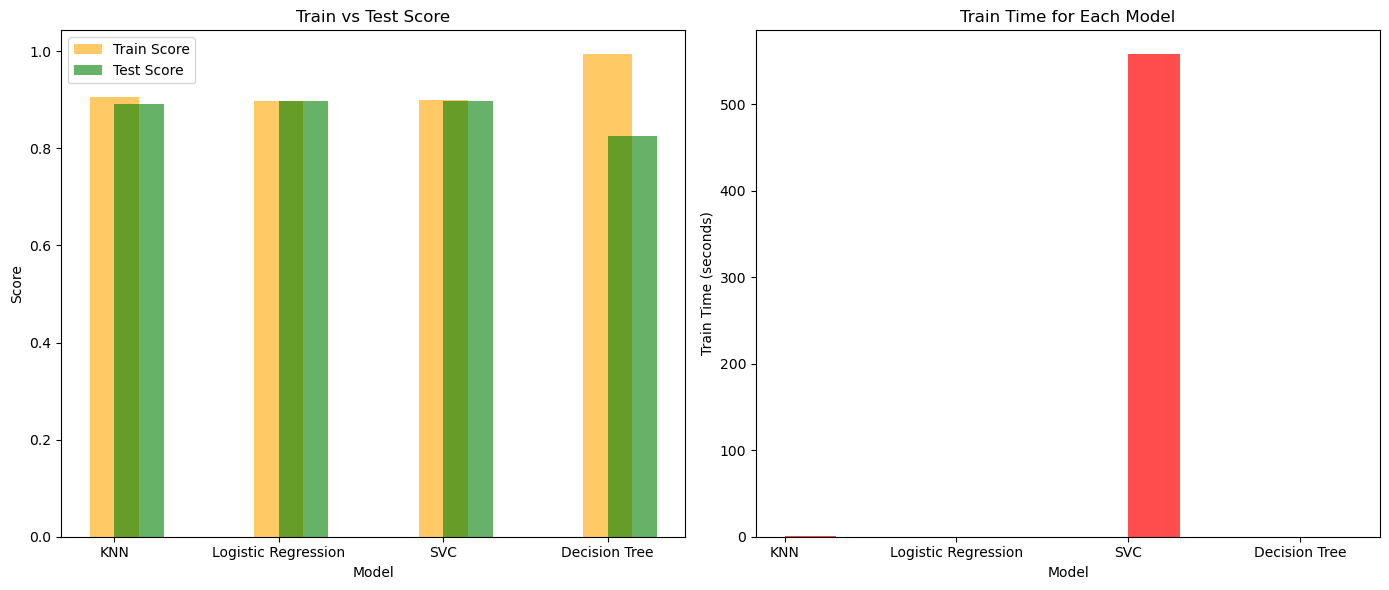

In [61]:
plot_graphs(results_default_df)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

Applying HyperParameter tuning and GridsearchCV

In [64]:
# Hyperparameter grids for GridSearchCV
param_grids = {
    'KNN': {'model__n_neighbors': [3, 5, 7, 9], 'model__metric': ['euclidean', 'manhattan']},
    'Logistic Regression': {'model__C': [0.1, 1, 10], 'model__solver': ['lbfgs', 'liblinear']},
    'SVC': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf'], 'model__gamma': ['scale', 'auto']},
    'Decision Tree': {'model__max_depth': [3, 5, 7, None], 'model__min_samples_split': [2, 5, 10], 'model__criterion': ['gini', 'entropy']}
}

In [71]:
# Store model results
results = []

def model_eval_stats(models, param_grids, X_train, y_train, X_test, y_test, results):
# Loop through models, apply Pipelines, GridSearchCV, and store results
    for model_name, model in models.items():
        print(f"Training {model_name} with Pipeline...")
        
        # Create a Pipeline with StandardScaler and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # First step: Scale the data
            ('model', model)               # Second step: Model fitting
        ])
        
        # Grid search
        grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, n_jobs=-1, verbose=1)
        
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        fit_time = time.time() - start_time
        
        # Best model and parameters
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        
        # Predict on test set
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test) # For ROC AUC calculation
        
        
        # Get the classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Train score (accuracy on training set)
        train_score = best_model.score(X_train, y_train)
        
        # Test score (accuracy on test set)
        test_score = best_model.score(X_test, y_test)
        
        # Extract Precision, Recall, F1-score, and Accuracy for each model
        precision = report['accuracy']  # Overall accuracy for the model
        recall = np.mean([report[str(i)]['recall'] for i in report if i.isdigit()])  # Average recall across classes
        accuracy = report['accuracy']  # Accuracy is already included in the classification report

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # ROC Curve and AUC compute and plot
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])  # For binary classification, using class 1 probabilities
        roc_auc = auc(fpr, tpr)
                    
        # Create subplots for Confusion Matrix and ROC Curve
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
        # Plot Confusion Matrix
        plot_confusion_matrix(axs[0], cm, model_name)
        # Plot ROC Curve :
        plot_roc_curve(axs[1], fpr, tpr, roc_auc, model_name)
        plt.tight_layout()
        plt.show()
        
        # Record the results
        results.append({
            'model': model_name,
            'train score': train_score,
            'test score': test_score,
            'train time': fit_time,
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy
        })

Training KNN with Pipeline...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


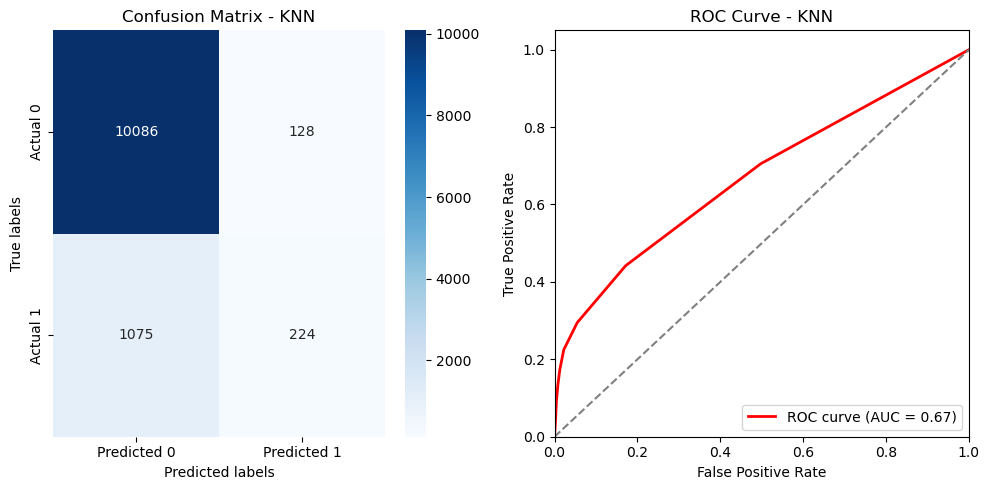

Training Logistic Regression with Pipeline...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


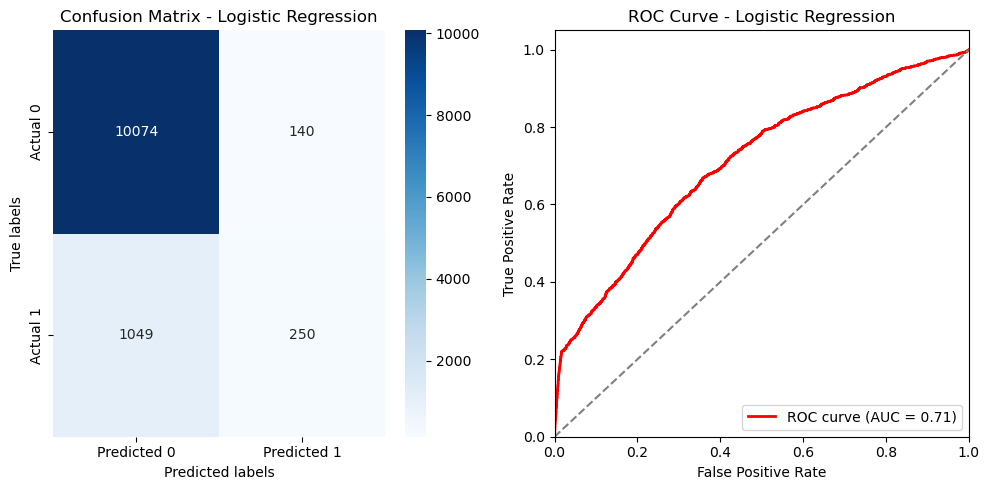

Training SVC with Pipeline...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
model_eval_stats(models, param_grids, X_train, y_train, X_test, y_test, results)

In [ ]:
# Convert results into DataFrame
results_df = pd.DataFrame(results)

In [ ]:
# Display the results
results_df

In [ ]:
plot_graphs(results_df)

##### Questions